In [109]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
# src: MNIST_Handwritten_Digits_STARTER.ipynb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# MNIST is a default dataset: we can load from torchvision directly
from torchvision import datasets

# Additional optimizer for tuning the hyperparameters
# src: https://optuna.org
import optuna

# used later for testing resnet
import torchvision.models as models

# used for storing the current best params set
import copy

#### For Reproducibility

In [2]:
torch_seed = 11
torch.manual_seed(torch_seed)

# Data Loading

In [3]:
data_folder = r'./data'

In [4]:
train_raw = datasets.MNIST(root=data_folder, train=True, download = True, transform=None)
test_raw =  datasets.MNIST(root=data_folder, train=False,download = True, transform=None)

## Now use the non-transformed data, to visualize those


#### Identifying the shapes of our data sets; expecting: (60k, 28, 28) and (10k, 28, 28), for train and test, respectively.

In [5]:
print(f'train shape: {train_raw.data.shape} ; \ntest  shape: {test_raw.data.shape}' )

train shape: torch.Size([60000, 28, 28]) ; 
test  shape: torch.Size([10000, 28, 28])


In [6]:
def create_subplot_image( axis_ref, data_structure, lbl_id):
    axis_ref.imshow(data_structure.data[lbl_id,:,:].numpy(), cmap='gray')
    axis_ref.axis('off')
    axis_ref.title.set_text(f"Label: {data_structure.targets[lbl_id]}")
    pass # only side effects (maybe should return the axis?)

In [7]:
def create_panel_of_consecutive_ex_images(init_idx, panel_dims = (3,5) , input_data = train_raw):
    fig , ax = plt.subplots(*panel_dims)
    X_plt_indx, Y_plt_indx = np.meshgrid(np.arange(panel_dims[0] ) , 
                                                   np.arange(panel_dims[1]))
    sequential_indexed_couple = zip(X_plt_indx.flatten(), Y_plt_indx.flatten() )
    [create_subplot_image(ax[plot_tuple_idx[0], plot_tuple_idx[1] ],
                          input_data, 
                          init_idx + seq_idx) for seq_idx, plot_tuple_idx in enumerate(sequential_indexed_couple)]
    pass

### Example of visualization

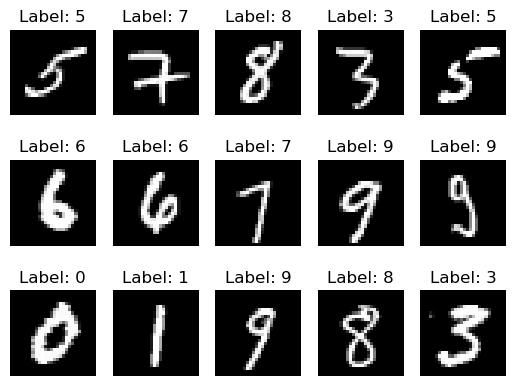

In [8]:
start_idx = 35
panel_dimension = (3,5)
create_panel_of_consecutive_ex_images(start_idx, panel_dims = panel_dimension)

## Create the appropriate transformation pipeline

In [9]:
# values inspired by this discussion 
# [1] https://stackoverflow.com/questions/63746182/correct-way-of-normalizing-and-scaling-the-mnist-dataset

# to check my reasoning check the values
max_data_value  = train_raw.data.max() # should be 255
print(f'Max data value: {max_data_value:3.0f}')

img_mean = torch.mean(train_raw.data, dtype=torch.float32)/max_data_value # mean of inputs,
# when data are scaled between 0 and 1 (from ToTensor)
# torch.Tensor.std(train_raw.data, dtype = torch.float32) this won't work: convertingo to numpy will do the trick

img_std = train_raw.data.to_dense().numpy().std()/max_data_value

print(f'mean: {img_mean.numpy():.4f}; std: {img_std:.4f}') # expected 0.1307 and 0.3081, respectively, 
# according to [1]

Max data value: 255
mean: 0.1307; std: 0.3081


In [10]:
# transformation pipeline
transform_pipeline = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((img_mean,), (img_std,))
                               ])

In [11]:
# Transformed data (to be used by the network)

train_data = datasets.MNIST(root=data_folder, train=True,  download = False, transform=transform_pipeline )
test_data =  datasets.MNIST(root=data_folder, train=False, download = False, transform=transform_pipeline)

In [12]:
_, img_rows, img_cols = (train_raw.data.numpy().shape)
network_input_dim = img_rows * img_cols

In [13]:
# helper functions to create data loader (and deal with batches)

def get_data_loaded_in_batches(current_data, batch_size, shuffle = True):
    return DataLoader(current_data, batch_size = batch_size, shuffle = shuffle)

def get_train_and_test_data_w_batch_size(batch_size, train_data = train_data, test_data = test_data ):
    return get_data_loaded_in_batches(train_data, batch_size, shuffle=True), \
           get_data_loaded_in_batches(test_data, batch_size, shuffle=False)

### Definition of the Neural Network (Non Convolutional)

In [14]:
# implementation inspired by the lectures
# and by https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py

class MNIST_MLP(nn.Module):
    def __init__(self , n_nodes, n_classes = 10):
        super().__init__()
        
        self.n_classes = n_classes
        self.activation = F.relu # for now we stick with ReLU
        self.output = F.log_softmax # multiple category
        self.fc1 = nn.Linear(network_input_dim, n_nodes[0])
        self.fc2 = nn.Linear(n_nodes[0], n_nodes[1])
        self.fc3 = nn.Linear(n_nodes[1], n_classes)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.output(self.fc3(x), dim=1)
        return x

In [15]:
def get_model_device(model):
    #adapted from: https://stackoverflow.com/questions/58926054/how-to-get-the-device-type-of-a-pytorch-module-conveniently
    return next(model.parameters()).device

In [110]:
def get_num_of_correctly_predicted_samples(predicted, labels):
    predicted_labels = torch.argmax(predicted.detach(),1) # possibly detach is not necessary here. Please clarify
    return torch.count_nonzero(torch.eq(predicted_labels, labels))

def evaluation_step(loss, _ ):
    return loss

def training_step(loss, optimizer):
    # init gradient
    optimizer.zero_grad()
    
    # compute gradient
    loss.backward()
    
    # update the model's weights
    optimizer.step()
    return loss

def batch_process(inputs, labels, optimizer, model, processing_fcn, device, criterion = F.cross_entropy):

    # estimate model's prediction
    output = model(inputs)

    # compute loss
    loss = criterion(output, labels)
    
    # do nothing or train, depending on the processing function
    loss = processing_fcn(loss, optimizer)
    
    # get the number of rightly predicted items
    currectly_predicted_samples = get_num_of_correctly_predicted_samples(output, labels)
    
    return loss, currectly_predicted_samples

In [111]:
def process_all_data_from_loader_n_get_metrics(data_loader, optimizer, model, processing_fcn,
                                               device = None, 
                                               criterion = F.cross_entropy):
    
    if not device:
        device = get_model_device(model)
    
    running_loss = 0.0 
    train_correct = 0 # init number of correctly classified items
    
    for index, data in enumerate(data_loader):
        
        inputs, labels = data
        
        # dump data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        current_loss, currectly_classified_items = batch_process(inputs, labels, optimizer, model, processing_fcn,  device, criterion) # batch_process
        running_loss += current_loss.item()
        train_correct += currectly_classified_items
    
    return running_loss, train_correct

In [112]:
def train_net_on_data(data_loader, optimizer, model,
                      device,
                      criterion = F.cross_entropy):
    model.train()
    return process_all_data_from_loader_n_get_metrics(data_loader, optimizer, model, training_step, device, criterion)


def eval_net_on_data(data_loader, model,
                     device,
                     criterion= F.cross_entropy):
    model.eval()
    return process_all_data_from_loader_n_get_metrics(data_loader, None, model, evaluation_step, device, criterion)

In [129]:
class PerformanceImprover():
    def __init__(self , max_count = 5, window = 2, loss_threshold = 1.0e-2, acc_threshold = 1.0e-2):
        self.best_val_loss_mean = np.infty
        self.best_val_acc_mean = 0.0
        self.counter = 0
        self.max_count = max_count
        self.loss_threshold = loss_threshold
        self.acc_threshold = acc_threshold
        self.window = window
        
    def is_improving(self, val_loss, val_accuracy):
        
        def get_mean_of_last_n_elements(list_of_values, num_of_elements):
            return np.mean(list_of_values[-num_of_elements:]) # handles automatically list shorter than num_of_elements
        
        if not val_loss:
            return True
        
        self.counter += 1 
        
        current_val_loss_mean = get_mean_of_last_n_elements(val_loss, self.window)
        current_val_acc_mean = get_mean_of_last_n_elements(val_accuracy , self.window)
        
        loss_has_improved = current_val_loss_mean < (self.best_val_loss_mean - self.loss_threshold)
        acc_has_improved = current_val_acc_mean  > (self.best_val_acc_mean + self.acc_threshold)
      
        if (loss_has_improved or acc_has_improved):
            
            self.counter = 0 # reset counter
            
            self.best_val_loss_mean = np.min([current_val_loss_mean, self.best_val_loss_mean])
            self.best_val_acc_mean = np.max([current_val_acc_mean, self.best_val_acc_mean])     
            return True
        
        elif (self.counter > self.max_count):
            return False
        
        else:
            return True                               

class TrainingStopper():
    def __init__(self, max_epochs = 100 , hist_horizon = 20, is_improving = PerformanceImprover().is_improving):
        self.max_epochs = max_epochs
        self.hist_horizon = hist_horizon
        self.current_epoch = 0
        self.is_improving = is_improving
        
    def __str__(self):
        return f"""Class Parameters:\n
                   Max Epochs: {self.max_epochs} 
                   History Horizon: {self.hist_horizon}
                   Accuracy Threshold:{self.accuracy_threshold}
                   Current Epoch:{self.current_epoch}"""
        
    def keep_training(self, val_loss, val_accuracy):  
        if ( self.current_epoch >= self.max_epochs): # max epochs reached: stop training
            print('Max Epochs reached')
            return False
        
        self.current_epoch += 1
        print(f"EPOCH: {self.current_epoch}")
        
        return self.is_improving(val_loss, val_accuracy)

In [130]:
def train_network_classification(net, train_loader, test_loader, optimizer, stopping_algorithm = TrainingStopper(), 
                                 criterion = F.cross_entropy):
    
    device = get_model_device(net)
    train_loss_history, training_acc_hist  = list(), list()
    val_loss_history, val_acc_hist = list(), list()
    
    num_train_samples = len(train_loader.dataset)
    num_val_samples = len(test_loader.dataset)
    
    best_test_accuracy = 0.0
    best_net_weights = net.state_dict()
    
    while stopping_algorithm.keep_training(val_loss_history, val_acc_hist):
        
        # training step
        training_loss, num_corrected_samples_train = \
            train_net_on_data(train_loader, optimizer, net, device, criterion)
        training_accuracy = num_corrected_samples_train / num_train_samples * 100.0
        
        train_loss_history.append(training_loss)
        training_acc_hist.append(training_accuracy)
        
        # evaluation step
        eval_loss, num_corrected_samples_test = eval_net_on_data(test_loader, net, device, criterion)
        testing_accuracy = num_corrected_samples_test / num_val_samples * 100.0
        
        val_loss_history.append(eval_loss)
        val_acc_hist.append(testing_accuracy)
        
        print(f'Training Accuracy: {training_accuracy:.4f}; Validation Accuracy: {testing_accuracy:.4f}')
                
        if testing_accuracy > best_test_accuracy:
            
            best_test_accuracy = testing_accuracy
            
            # Create a deep copy of the model's parameters, otherwise dict is stored by reference
            best_net_weights = copy.deepcopy(net.state_dict())
                
#     # load the best net on test data
    net.load_state_dict(best_net_weights)
    
    return net, (train_loss_history, training_acc_hist), (val_loss_history, val_acc_hist)

#### Hyperparameters not optimized (fixed)


In [131]:
BATCH_SIZE = 64
HIDDEN_NODES = (64,64)
LEARNING_RATE = lr=0.00011

In [132]:
model = MNIST_MLP(HIDDEN_NODES)

In [133]:
# current execution
train_data_loaded , test_data_loaded = get_train_and_test_data_w_batch_size(BATCH_SIZE )

# model creation (use CPU: faster for small networks)
model = MNIST_MLP(HIDDEN_NODES)

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# algo_stopper = TrainingStopper(max_epochs=2)
# print(algo_stopper)

In [134]:
model, (tr_loss, tr_acc), (val_loss, val_cc)= train_network_classification(model, train_data_loaded, test_data_loaded,optimizer)


EPOCH: 1
Training Accuracy: 81.9517; Validation Accuracy: 90.8400
EPOCH: 2
Training Accuracy: 91.2900; Validation Accuracy: 92.5200
EPOCH: 3
Training Accuracy: 92.6050; Validation Accuracy: 93.3900
EPOCH: 4
Training Accuracy: 93.5850; Validation Accuracy: 94.0900
EPOCH: 5
Training Accuracy: 94.3500; Validation Accuracy: 94.5800
EPOCH: 6
Training Accuracy: 94.9200; Validation Accuracy: 95.0900
EPOCH: 7
Training Accuracy: 95.4583; Validation Accuracy: 95.2900
EPOCH: 8
Training Accuracy: 95.8633; Validation Accuracy: 95.4200
EPOCH: 9
Training Accuracy: 96.1800; Validation Accuracy: 95.8200
EPOCH: 10
Training Accuracy: 96.4450; Validation Accuracy: 96.1600
EPOCH: 11
Training Accuracy: 96.7800; Validation Accuracy: 96.1700
EPOCH: 12
Training Accuracy: 96.9767; Validation Accuracy: 96.3700
EPOCH: 13
Training Accuracy: 97.1467; Validation Accuracy: 96.2300
EPOCH: 14
Training Accuracy: 97.3183; Validation Accuracy: 96.4100
EPOCH: 15
Training Accuracy: 97.4867; Validation Accuracy: 96.7100
EPOC

### Optimize hyperparameters with Optuna

In [ ]:
# inspired by https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py

def objective(trial):
    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_mnist()

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

### Get use of HW acceleration, if available


In [ ]:
def get_HW_acceleration_if_available():
    try:
        if torch.backends.mps.is_available():
            return 'mps'
    except AttributeError:
        pass
        
    if torch.cuda.is_available():
        return 'cuda'
    
    return 'cpu'

In [ ]:
device = get_HW_acceleration_if_available()

In [ ]:
model.to(device)

### Try with Resnet

In [ ]:
import torch


# Load a pre-trained ResNet-18 model
resnet = (models.resnet18(pretrained=True)).to('mps')


In [ ]:
import torch.nn as nn

# Modify the first convolutional layer to accept 1 input channel
# The original input channels were 3 (RGB), change it to 1
resnet.conv1 = (nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)).to('mps')


In [ ]:
num_classes = 10  # MNIST has 10 classes (digits 0-9)
resnet.fc = (nn.Linear(resnet.fc.in_features, num_classes)).to('mps')


In [ ]:
algo_stopper = TrainingStopper(max_epochs=1)


In [ ]:
%%time
train_network_classification(resnet, train_data_loaded, test_data_loaded, algo_stopper, optim.Adam(resnet.parameters(), lr= 0.00045), criterion=F.cross_entropy, device='mps')
